In [53]:
#
# Licensed to the Apache Software Foundation (ASF) under one or more
# contributor license agreements.  See the NOTICE file distributed with
# this work for additional information regarding copyright ownership.
# The ASF licenses this file to You under the Apache License, Version 2.0
# (the "License"); you may not use this file except in compliance with
# the License.  You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

"""
The K-means algorithm written from scratch against PySpark. In practice,
one may prefer to use the KMeans algorithm in ML, as shown in
examples/src/main/python/ml/kmeans_example.py.

This example requires NumPy (http://www.numpy.org/).
"""
from __future__ import print_function

import sys

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [46]:
def parseVector(line):
    return np.array([float(x) for x in line.split(',')])


def closestPoint(p, centers):
    bestIndex = 0
    closest = float("+inf")
    for i in range(len(centers)):
        tempDist = np.sum((p - centers[i]) ** 2)
        #Manhattan distance
#         tempDist = np.sum((p - centers[i]))
        if tempDist < closest:
            closest = tempDist
            bestIndex = i
    return bestIndex

def compute_error(p, centers):
    center = centers[closestPoint(p,centers)]
    return np.sqrt(sum([x**2 for x in (p - center)]))
    

2 - WSSE =  30597570.952287134
3 - WSSE =  32083856.842496645
4 - WSSE =  31757608.397977192
5 - WSSE =  24497753.460582923
6 - WSSE =  17106421.182754103
7 - WSSE =  4087179.055760413
8 - WSSE =  10584115.117930831
9 - WSSE =  10087469.351771986
Final centers: [array([84.12849522, 82.43162084, 81.61007623, 84.4843015 , 83.7819654 ]), array([61.18044077, 60.13089088, 61.55094828, 60.68988467, 63.19990697]), array([23.52219619, 23.66012527, 21.80532119, 20.930697  , 20.39620795]), array([64.48741414, 60.32721714, 63.98971968, 64.16150006, 64.42192917]), array([101.17154958, 100.26157865, 102.44576573, 103.87307861,
       102.76917126]), array([20.33637888, 21.8711501 , 23.80843601, 22.99236541, 20.69850063]), array([1.96526804, 4.27206202, 1.70463761, 2.94959142, 2.09581472]), array([4.69670328, 2.40767319, 3.71218454, 4.29514969, 4.23309907]), array([24.19420797, 24.72093998, 20.40776048, 24.88246307, 21.4746588 ])]


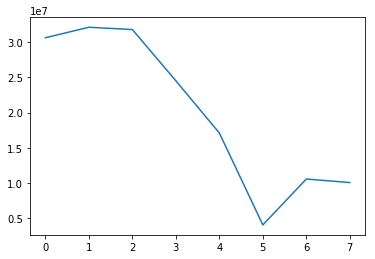

In [65]:
spark = SparkSession\
    .builder\
    .appName("PythonKMeans")\
    .getOrCreate()

lines = spark.read.text('smallpointdata2018.txt').rdd.map(lambda r: r[0])
# lines.takeSample(True, 100000, seed=int(datetime.timestamp(datetime.now())))

data = lines.map(parseVector).cache()
convergeDist = 0.0001
tempDist = 1.0
i = 0
sse_list = list()
for K in range(2,10):
    kPoints = data.takeSample(False, K, int(datetime.timestamp(datetime.now())))
    while tempDist > convergeDist:
        closest = data.map(lambda p: (closestPoint(p, kPoints), (p, 1)))
        pointStats = closest.reduceByKey(lambda p1_c1, p2_c2:
                                         (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
        newPoints = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()
        tempDist = sum(np.sum((kPoints[iK] - p) ** 2) for (iK, p) in newPoints)
        ##updates new points coordinates
        for (iK, p) in newPoints:
            kPoints[iK] = p
    WSSSE = data.map(lambda point: compute_error(point, kPoints)).reduce(lambda x, y: x + y)
    sse_list.append(WSSSE)
    print(K, "- WSSE = ", WSSSE)
print("Final centers: " + str(kPoints))
sse_vector = np.array(sse_list)
plt.plot(sse_vector)
plt.show()
spark.stop()